In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
# 设置全局字体大小
plt.rcParams['font.size'] = 12

# 参数
d = 0.5
K = 1
c = 1500
f = 37500

d1, d2, d3 = -(K + 1) * d / 2, -(K - 1) * d / 2, (K + 1) * d / 2
p1 = np.array([d1, 0])
p2 = np.array([d2, 0])
p3 = np.array([d3, 0])

## 临界距离

$\tau_{12}$或$\tau_{23}$等于半周期时距离, 声源位置不当会导致跨周期模糊/相位模糊

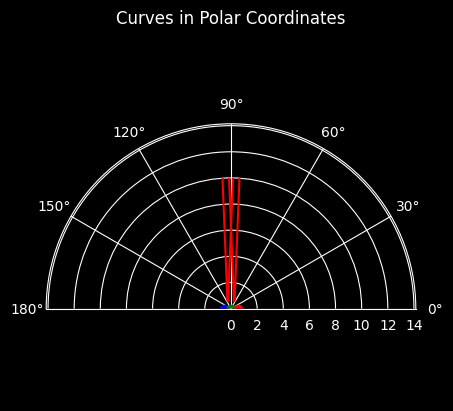

In [44]:
# 创建一个网格
x = np.linspace(-10, 10, 400)
y = np.linspace(0, 10, 400)
X, Y = np.meshgrid(x, y)
S = np.vstack((X.ravel(), Y.ravel())).T

# 计算P1S、P2S和P3S的距离
r1 = np.sqrt((S[:, 0] - p1[0])**2 + (S[:, 1] - p1[1])**2)
r2 = np.sqrt((S[:, 0] - p2[0])**2 + (S[:, 1] - p2[1])**2)
r3 = np.sqrt((S[:, 0] - p3[0])**2 + (S[:, 1] - p3[1])**2)

tau12 = np.abs(r1 - r2) / c
tau23 = np.abs(r2 - r3) / c
# 找到同时满足条件的点S
condition1 = tau12 - 1 / f / 2
condition2 = tau23 - 1 / f / 2
condition1 = condition1.reshape(X.shape)
condition2 = condition2.reshape(X.shape)

# 使用matplotlib画图
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.xlim(0, np.pi)
r, theta = np.meshgrid(np.linspace(0, np.max(S), 400), np.linspace(0, 2*np.pi, 400))
# 将X, Y转换为极坐标
R = np.sqrt(X**2 + Y**2)
Theta = np.arctan2(Y, X)

ax.contour(Theta, R, condition1, levels=[0], colors='r')
ax.contour(Theta, R, condition2, levels=[0], colors='r')

# 将P1, P2, P3的坐标转换为极坐标
P1_theta, P1_r = np.arctan2(p1[1], p1[0]), np.sqrt(p1[0]**2 + p1[1]**2)
P2_theta, P2_r = np.arctan2(p2[1], p2[0]), np.sqrt(p2[0]**2 + p2[1]**2)
P3_theta, P3_r = np.arctan2(p3[1], p3[0]), np.sqrt(p3[0]**2 + p3[1]**2)

ax.plot(P1_theta, P1_r, 'bo')  # 点P1
ax.plot(P2_theta, P2_r, 'go')  # 点P2
ax.plot(P3_theta, P3_r, 'ro')  # 点P3

ax.set_title('Curves in Polar Coordinates')
plt.show()

## 误差分析

### 时延误差引起的测向/测距误差

#### 测向误差

方位角测量不确定度$u_\theta = \sqrt{\overline{\Delta\theta^2}}= |\cot\theta|\cdot\sqrt{\frac{u_c^2}{c^2} + \frac{u_d^2}{d^2} + \frac{u_{\tau_{13}}^2}{\tau_{13}}}$, 当c和d理想, $u_\theta = \sqrt{\overline{\Delta\theta^2}}= |\cot\theta|\cdot\sqrt{\frac{u_{\tau_{13}}^2}{\tau_{13}^2}}$

时延差$\tau_{12}=\frac{r_1-r_2}{c}, \tau_{13}=\tau_{12}+\tau_{23}$, 则$u_{\tau_{13}}=u_{\tau_{12}}+u_{\tau_{23}}=u_{\tau_{12}}\sqrt{1+K^2}$

因此$u_\theta = \frac{c|\cot\theta|u_{\tau_{12}}\sqrt{1+K^2}}{|r_1-r_3|}$

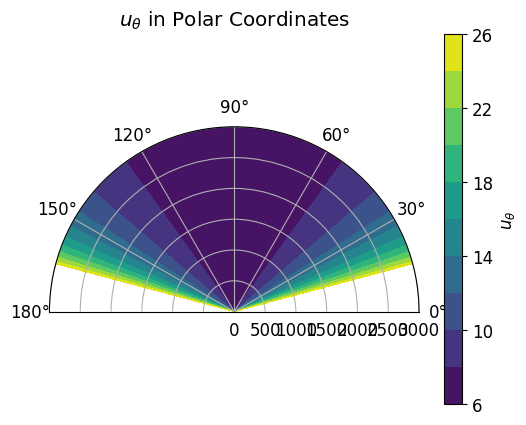

In [5]:
# 参数
d = 0.5
K = 1
c = 1500
f = 37500
T = 1 / f

d1, d2, d3 = -(K + 1) * d / 2, -(K - 1) * d / 2, (K + 1) * d / 2
p1 = np.array([d1, 0])
p2 = np.array([d2, 0])
p3 = np.array([d3, 0])

u_tau12 = 2 * T  # 时延差估计误差/不确定度

# 创建极坐标网格
r = np.linspace(0, 3000, 400)
theta = np.linspace(np.pi/12, np.pi/12*11, 400)
R, Theta = np.meshgrid(r, theta)

# 将极坐标转换为笛卡尔坐标
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

# 计算每个点到P1和P3的距离
R1 = np.sqrt((X - p1[0])**2 + (Y - p1[1])**2)
R3 = np.sqrt((X - p3[0])**2 + (Y - p3[1])**2)

# 计算每个点对应的u_theta
with np.errstate(divide='ignore', invalid='ignore'):
    tan_Theta = np.tan(Theta)
    tan_Theta[tan_Theta == 0] = np.nan  # 避免除以零
    R_diff = np.abs(R1 - R3)
    R_diff[R_diff == 0] = np.nan  # 避免除以零
    # 计算每个点对应的u_theta
    u_theta = c * np.abs(1 / tan_Theta) * u_tau12 * np.sqrt(1 + K**2) / R_diff

u_theta = u_theta / np.pi * 180  # 转换为角度

# 绘制u_theta的等高线图
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.xlim(0, np.pi)
contour = ax.contourf(Theta, R, u_theta, levels=10, cmap='viridis')  # 分为10个等级
fig.colorbar(contour, ax=ax, label=r'$u_\theta$')
ax.set_title(r'$u_\theta$ in Polar Coordinates')
# 保存图形为PDF格式
# plt.savefig('u_theta_plot.pdf', format='pdf')
plt.show()

#### 测距误差

距离测量不确定度